In [ ]:
# default_exp hw5

# Import

In [ ]:
# export
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import librosa
import librosa.display

from cs371.utils import *

# HW5

Implement kruskals MST algorithm

In [ ]:
from cs371.module3 import DisjointSetsMergeByHeightAndPathCompression2 as DisjointSet

In [ ]:
N  = 20
ps = np.clip(np.random.normal(size=(N, 2)), -2, 2)
ps = np.unique(ps, axis=0)
nodes = [tuple((tuple(p), chr(i + 97))) for i, p in enumerate(ps)]

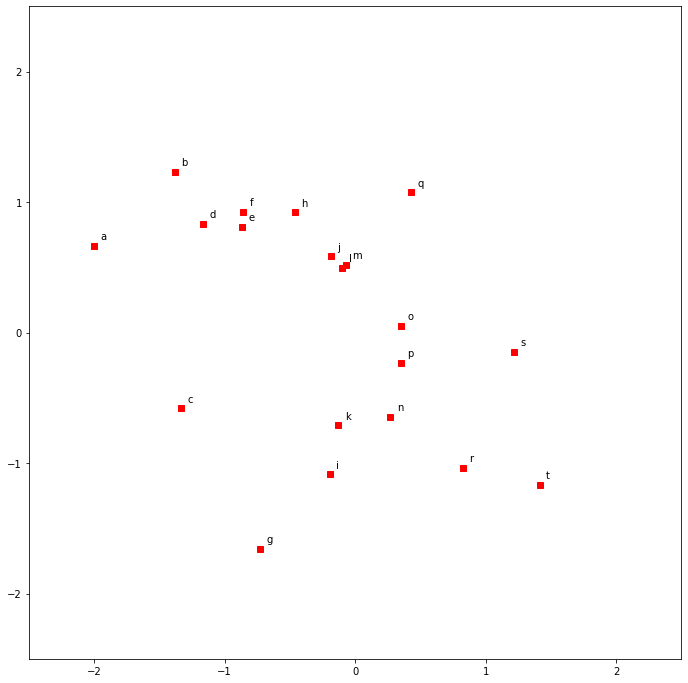

In [ ]:
plt.figure(figsize=(12, 12))
plt.gca().set_xlim(-2.5, 2.5)
plt.gca().set_ylim(-2.5, 2.5)
plt.gca().set_aspect(1)

for node in nodes:
    p, s = node
    plt.plot(p[0], p[1], 'rs')
    plt.text(p[0]+0.05, p[1]+0.05, s)

In [ ]:
def kruskals(nodes, weights):
    edges = []

    ds = DisjointSet(nodes)
    weights = sorted(weights, key=lambda x: x[1])
    for (node1, node2), weight in weights:
        if not ds.find(node1, node2):
            ds.union(node1, node2)
            edges.append((node1, node2))

    return edges

In [ ]:
weights = []
for i in range(0, len(nodes)):
    for j in range(i+1, len(nodes)):
        node1, node2 = nodes[i], nodes[j]
        p1, p2 = node1[0], node2[0]
        weights.append(((node1, node2), np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)))

In [ ]:
edges = kruskals(nodes, weights)

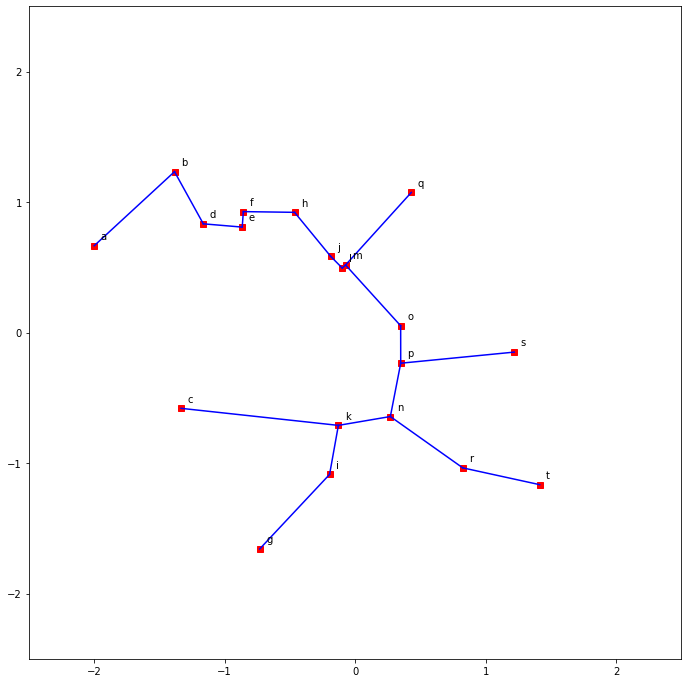

In [ ]:
plt.figure(figsize=(12, 12))
plt.gca().set_xlim(-2.5, 2.5)
plt.gca().set_ylim(-2.5, 2.5)
plt.gca().set_aspect(1)

for node in nodes:
    p, s = node
    plt.plot(p[0], p[1], 'rs')
    plt.text(p[0]+0.05, p[1]+0.05, s)
    
for edge in edges:
    node1, node2 = edge
    p1, p2 = node1[0], node2[0]
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], '-b')

Looks correct, now try to implement dendrogram code

In [ ]:
from cs371.module17 import TreeNode, BinaryTree, height

In [ ]:
treenodes = [TreeNode(node[0], node[1]) for node in nodes]

In [ ]:
weights = []
for i in range(0, len(treenodes)):
    for j in range(i+1, len(treenodes)):
        node1, node2 = treenodes[i], treenodes[j]
        p1, p2 = node1.key, node2.key
        weights.append(((node1, node2), np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)))

In [ ]:
def get_dendrogram(treenodes, weights, default):
    # Cache weight and leafs; note that all input nodes are leaf nodes, so weight of zero
    for treenode in treenodes: 
        treenode._w = default
        treenode._l = 1

    roots = dict(zip(treenodes, treenodes)) # initialize so nodes are their own roots
    ds = DisjointSet(treenodes)
    weights = sorted(weights, key=lambda x: x[1])
    for (leaf1, leaf2), weight in weights:
        if not ds.find(leaf1, leaf2):
            # Replace with disjointset roots
            leaf1 = ds._root(leaf1)
            leaf2 = ds._root(leaf2)
            # Get current roots
            node1 = roots[leaf1]
            node2 = roots[leaf2]
            # Create parent node
            root = TreeNode(None, None)
            root.L = node1
            root.R = node2
            root._w = weight
            root._l = node1._l + node2._l
            # Take union and update root
            ds.union(leaf1, leaf2)
            roots[ds._root(leaf1)] = root

    return root

In [ ]:
def _draw_dendrogram(self, y1, y2):
    if not (self.L and self.R):
        x, y = -self._w, (y1+y2)/2
        plt.plot(x,       y, 'rs')
        plt.text(x+0.025, y, self.val)
        return x, y
    
    h = y2-y1
    l_L, l_R = self.L._l, self.R._l
    h_L = (l_L/(l_L + l_R))*h
    x, y = -self._w, y1+h_L
    plt.plot(x, y, 'rs')    
    p1 = self.L._draw_dendrogram(    y1, y1+h_L)
    p2 = self.R._draw_dendrogram(y1+h_L,     y2)
    plt.plot([x, p1[0]], [y, p1[1]], '-r')
    plt.plot([x, p2[0]], [y, p2[1]], '-r')
    return x, y

In [ ]:
TreeNode._draw_dendrogram = _draw_dendrogram

Test it out

In [ ]:
root = get_dendrogram(treenodes, weights, 0)

(-1.212977154906178, 0.05)

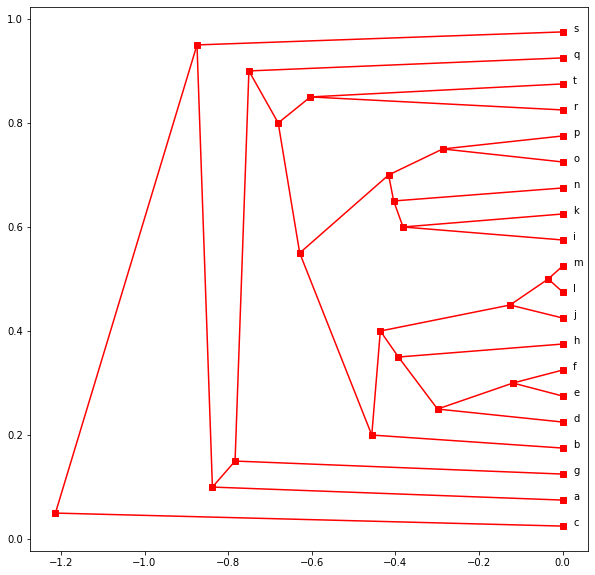

In [ ]:
plt.figure(figsize=(10, 10))
root._draw_dendrogram(0, 1)

We should be good to go now; first is Needleman-Wunsch

In [ ]:
def load_blosum(filename):
    fin = open(filename)
    lines = [l for l in fin.readlines() if l[0] != "#"]
    fin.close()
    symbols = lines[0].split()
    X = [[int(x) for x in l.split()] for l in lines[1::]]
    X = np.array(X, dtype=int)
    N = X.shape[0]
    costs = {}
    for i in range(N-1):
        for j in range(i, N):
            c = X[i, j]
            if j == N-1:
                costs[symbols[i]] = c
            else:
                costs[symbols[i]+symbols[j]] = c
                costs[symbols[j]+symbols[i]] = c
    return costs

In [ ]:
import json

In [ ]:
costs = load_blosum('data/blosum62.bla')

In [ ]:
species = json.load(open('data/organisms.json'))

Similarity between Dog and Hyaena using BLOSUM62 should be 1375, so try this out first

In [ ]:
def needleman_wunsch_score(DNA1, DNA2, costs):
    M, N = len(DNA1), len(DNA2)
    
    arr_dp = np.zeros((M+1, N+1))
    for i in range(M+1):
        for j in range(N+1):
            if i == 0 and j == 0: continue
            elif i == 0:
                arr_dp[0, j] = arr_dp[0, j-1] + costs[DNA2[j-1]] # Simply append cost
            elif j == 0:
                arr_dp[i, 0] = arr_dp[i-1, 0] + costs[DNA1[i-1]] # Simply append cost
            else:
                arr_dp[i, j] = max(arr_dp[i-1, j-1] + costs[DNA2[j-1] + DNA1[i-1]],
                                   arr_dp[i, j-1] + costs[DNA2[j-1]],
                                   arr_dp[i-1, j] + costs[DNA1[i-1]])
    
    return arr_dp[-1, -1]

In [ ]:
needleman_wunsch_score(species['Dog'], 
                       species['Hyaena'],
                       costs)

1375.0

In [ ]:
needleman_wunsch_score(species['Domestic Cat'], 
                       species['Cougar'],
                       costs)

1427.0

Compute weights

In [ ]:
treenodes = [TreeNode(specie, specie) for specie in species.keys()]

In [ ]:
weights = []
for i in range(0, len(treenodes)):
    for j in range(i+1, len(treenodes)):
        node1, node2 = treenodes[i], treenodes[j]
        specie1, specie2 = node1.key, node2.key
        weight = needleman_wunsch_score(species[specie1], 
                                        species[specie2],
                                        costs)
        print(f'{specie1} - {specie2} : {weight}')
        weights.append(((node1, node2), weight))

Wild boar - Horse : 1347.0
Wild boar - White-tailed deer : 1341.0
Wild boar - Reindeer : 1339.0
Wild boar - Domestic Yak : 1345.0
Wild boar - Cattle : 1361.0
Wild boar - Asian black bear : 1327.0
Wild boar - American black bear : 1313.0
Wild boar - Polar bear : 1325.0
Wild boar - Giant panda : 1315.0
Wild boar - African bush elephant : 1259.0
Wild boar - Northern giraffe : 1354.0
Wild boar - Indian rhinoceros : 1354.0
Wild boar - White rhinoceros : 1365.0
Wild boar - Eastern gray kangaroo : 1298.0
Wild boar - Virginia opossum : 1293.0
Wild boar - Wallaby : 1298.0
Wild boar - Koala : 1255.0
Wild boar - Platypus : 1281.0
Wild boar - Brown rat : 1285.0
Wild boar - House mouse : 1275.0
Wild boar - Guinea pig : 1283.0
Wild boar - Chipmunk : 1312.0
Wild boar - American beaver : 1307.0
Wild boar - Fox squirrel : 1304.0
Wild boar - Malayan porcupine : 1326.0
Wild boar - Human : 1269.0
Wild boar - Neanderthal : 1262.0
Wild boar - Chimpanzee : 1261.0
Wild boar - Orangutan : 1247.0
Wild boar - Go

Reindeer - Hyaena : 1354.0
Reindeer - Dingo : 1328.0
Reindeer - Indian wolf : 1329.0
Reindeer - Eastern wolf : 1302.0
Reindeer - Red fox : 1341.0
Reindeer - Goldfish : 1225.0
Reindeer - Dolphin : 1343.0
Reindeer - Fugu rubripes : 1214.0
Reindeer - Great white shark : 1226.0
Reindeer - Russels viper : 1090.0
Reindeer - Chameleon : 1004.0
Reindeer - Bearded Dragon : 1039.0
Reindeer - American alligator : 1185.0
Reindeer - Gray treefrog : 1158.0
Reindeer - Fire salamander : 1201.0
Reindeer - Eastern newt : 1197.0
Reindeer - Alpine newt : 1185.0
Reindeer - Edible frog : 1184.0
Reindeer - Chinese giant salamander : 1146.0
Reindeer - Domestic Cat : 1349.0
Reindeer - Cheetah : 1348.0
Reindeer - Cougar : 1353.0
Reindeer - Tiger : 1346.0
Reindeer - Ocelot : 1339.0
Reindeer - Cardinal : 1176.0
Reindeer - Bald Eagle : 1170.0
Reindeer - Eurasian golden oriole : 1155.0
Reindeer - Mourning dove : 1160.0
Reindeer - Eurasian eagle-owl : 1140.0
Reindeer - American robin : 1155.0
Reindeer - Monarch butt

Asian black bear - Termite : 1025.0
Asian black bear - Spotted Lanternfly : 834.0
American black bear - Polar bear : 1413.0
American black bear - Giant panda : 1396.0
American black bear - African bush elephant : 1269.0
American black bear - Northern giraffe : 1352.0
American black bear - Indian rhinoceros : 1355.0
American black bear - White rhinoceros : 1339.0
American black bear - Eastern gray kangaroo : 1301.0
American black bear - Virginia opossum : 1306.0
American black bear - Wallaby : 1301.0
American black bear - Koala : 1251.0
American black bear - Platypus : 1275.0
American black bear - Brown rat : 1298.0
American black bear - House mouse : 1286.0
American black bear - Guinea pig : 1260.0
American black bear - Chipmunk : 1315.0
American black bear - American beaver : 1299.0
American black bear - Fox squirrel : 1306.0
American black bear - Malayan porcupine : 1312.0
American black bear - Human : 1276.0
American black bear - Neanderthal : 1276.0
American black bear - Chimpanzee

African bush elephant - Indian wolf : 1274.0
African bush elephant - Eastern wolf : 1251.0
African bush elephant - Red fox : 1276.0
African bush elephant - Goldfish : 1198.0
African bush elephant - Dolphin : 1256.0
African bush elephant - Fugu rubripes : 1183.0
African bush elephant - Great white shark : 1198.0
African bush elephant - Russels viper : 1077.0
African bush elephant - Chameleon : 1002.0
African bush elephant - Bearded Dragon : 1038.0
African bush elephant - American alligator : 1152.0
African bush elephant - Gray treefrog : 1138.0
African bush elephant - Fire salamander : 1171.0
African bush elephant - Eastern newt : 1198.0
African bush elephant - Alpine newt : 1167.0
African bush elephant - Edible frog : 1156.0
African bush elephant - Chinese giant salamander : 1150.0
African bush elephant - Domestic Cat : 1276.0
African bush elephant - Cheetah : 1278.0
African bush elephant - Cougar : 1275.0
African bush elephant - Tiger : 1269.0
African bush elephant - Ocelot : 1265.0
A

White rhinoceros - Bald Eagle : 1180.0
White rhinoceros - Eurasian golden oriole : 1169.0
White rhinoceros - Mourning dove : 1182.0
White rhinoceros - Eurasian eagle-owl : 1158.0
White rhinoceros - American robin : 1170.0
White rhinoceros - Monarch butterfly : 1006.0
White rhinoceros - Common clothes moth : 987.0
White rhinoceros - Asian lady beetle : 979.0
White rhinoceros - Housefly : 1014.0
White rhinoceros - Black garden ant : 923.0
White rhinoceros - Western honeybee : 689.0
White rhinoceros - Termite : 1041.0
White rhinoceros - Spotted Lanternfly : 824.0
Eastern gray kangaroo - Virginia opossum : 1355.0
Eastern gray kangaroo - Wallaby : 1429.0
Eastern gray kangaroo - Koala : 1292.0
Eastern gray kangaroo - Platypus : 1298.0
Eastern gray kangaroo - Brown rat : 1288.0
Eastern gray kangaroo - House mouse : 1271.0
Eastern gray kangaroo - Guinea pig : 1264.0
Eastern gray kangaroo - Chipmunk : 1304.0
Eastern gray kangaroo - American beaver : 1293.0
Eastern gray kangaroo - Fox squirrel :

Koala - Mourning dove : 1150.0
Koala - Eurasian eagle-owl : 1115.0
Koala - American robin : 1144.0
Koala - Monarch butterfly : 978.0
Koala - Common clothes moth : 969.0
Koala - Asian lady beetle : 947.0
Koala - Housefly : 976.0
Koala - Black garden ant : 900.0
Koala - Western honeybee : 680.0
Koala - Termite : 993.0
Koala - Spotted Lanternfly : 842.0
Platypus - Brown rat : 1269.0
Platypus - House mouse : 1267.0
Platypus - Guinea pig : 1286.0
Platypus - Chipmunk : 1287.0
Platypus - American beaver : 1266.0
Platypus - Fox squirrel : 1290.0
Platypus - Malayan porcupine : 1300.0
Platypus - Human : 1238.0
Platypus - Neanderthal : 1236.0
Platypus - Chimpanzee : 1239.0
Platypus - Orangutan : 1223.0
Platypus - Gorilla : 1235.0
Platypus - Bonobo : 1231.0
Platypus - Dog : 1284.0
Platypus - Hyaena : 1290.0
Platypus - Dingo : 1294.0
Platypus - Indian wolf : 1292.0
Platypus - Eastern wolf : 1268.0
Platypus - Red fox : 1290.0
Platypus - Goldfish : 1229.0
Platypus - Dolphin : 1262.0
Platypus - Fugu r

Chipmunk - Cougar : 1322.0
Chipmunk - Tiger : 1321.0
Chipmunk - Ocelot : 1319.0
Chipmunk - Cardinal : 1147.0
Chipmunk - Bald Eagle : 1158.0
Chipmunk - Eurasian golden oriole : 1138.0
Chipmunk - Mourning dove : 1136.0
Chipmunk - Eurasian eagle-owl : 1127.0
Chipmunk - American robin : 1133.0
Chipmunk - Monarch butterfly : 1008.0
Chipmunk - Common clothes moth : 992.0
Chipmunk - Asian lady beetle : 983.0
Chipmunk - Housefly : 1008.0
Chipmunk - Black garden ant : 921.0
Chipmunk - Western honeybee : 697.0
Chipmunk - Termite : 1030.0
Chipmunk - Spotted Lanternfly : 838.0
American beaver - Fox squirrel : 1310.0
American beaver - Malayan porcupine : 1325.0
American beaver - Human : 1274.0
American beaver - Neanderthal : 1273.0
American beaver - Chimpanzee : 1283.0
American beaver - Orangutan : 1251.0
American beaver - Gorilla : 1257.0
American beaver - Bonobo : 1275.0
American beaver - Dog : 1309.0
American beaver - Hyaena : 1322.0
American beaver - Dingo : 1321.0
American beaver - Indian wolf

Neanderthal - Cardinal : 1169.0
Neanderthal - Bald Eagle : 1172.0
Neanderthal - Eurasian golden oriole : 1161.0
Neanderthal - Mourning dove : 1165.0
Neanderthal - Eurasian eagle-owl : 1167.0
Neanderthal - American robin : 1159.0
Neanderthal - Monarch butterfly : 992.0
Neanderthal - Common clothes moth : 978.0
Neanderthal - Asian lady beetle : 960.0
Neanderthal - Housefly : 994.0
Neanderthal - Black garden ant : 924.0
Neanderthal - Western honeybee : 668.0
Neanderthal - Termite : 1031.0
Neanderthal - Spotted Lanternfly : 844.0
Chimpanzee - Orangutan : 1339.0
Chimpanzee - Gorilla : 1382.0
Chimpanzee - Bonobo : 1419.0
Chimpanzee - Dog : 1249.0
Chimpanzee - Hyaena : 1271.0
Chimpanzee - Dingo : 1259.0
Chimpanzee - Indian wolf : 1258.0
Chimpanzee - Eastern wolf : 1233.0
Chimpanzee - Red fox : 1265.0
Chimpanzee - Goldfish : 1255.0
Chimpanzee - Dolphin : 1262.0
Chimpanzee - Fugu rubripes : 1221.0
Chimpanzee - Great white shark : 1217.0
Chimpanzee - Russels viper : 1097.0
Chimpanzee - Chameleon

Dingo - Great white shark : 1218.0
Dingo - Russels viper : 1067.0
Dingo - Chameleon : 1012.0
Dingo - Bearded Dragon : 1025.0
Dingo - American alligator : 1156.0
Dingo - Gray treefrog : 1162.0
Dingo - Fire salamander : 1201.0
Dingo - Eastern newt : 1208.0
Dingo - Alpine newt : 1175.0
Dingo - Edible frog : 1189.0
Dingo - Chinese giant salamander : 1167.0
Dingo - Domestic Cat : 1398.0
Dingo - Cheetah : 1386.0
Dingo - Cougar : 1393.0
Dingo - Tiger : 1399.0
Dingo - Ocelot : 1386.0
Dingo - Cardinal : 1165.0
Dingo - Bald Eagle : 1165.0
Dingo - Eurasian golden oriole : 1140.0
Dingo - Mourning dove : 1154.0
Dingo - Eurasian eagle-owl : 1124.0
Dingo - American robin : 1149.0
Dingo - Monarch butterfly : 1007.0
Dingo - Common clothes moth : 987.0
Dingo - Asian lady beetle : 955.0
Dingo - Housefly : 1006.0
Dingo - Black garden ant : 899.0
Dingo - Western honeybee : 689.0
Dingo - Termite : 1041.0
Dingo - Spotted Lanternfly : 827.0
Indian wolf - Eastern wolf : 1394.0
Indian wolf - Red fox : 1422.0
In

Great white shark - Domestic Cat : 1223.0
Great white shark - Cheetah : 1233.0
Great white shark - Cougar : 1227.0
Great white shark - Tiger : 1226.0
Great white shark - Ocelot : 1213.0
Great white shark - Cardinal : 1204.0
Great white shark - Bald Eagle : 1206.0
Great white shark - Eurasian golden oriole : 1197.0
Great white shark - Mourning dove : 1223.0
Great white shark - Eurasian eagle-owl : 1200.0
Great white shark - American robin : 1218.0
Great white shark - Monarch butterfly : 995.0
Great white shark - Common clothes moth : 964.0
Great white shark - Asian lady beetle : 958.0
Great white shark - Housefly : 990.0
Great white shark - Black garden ant : 904.0
Great white shark - Western honeybee : 661.0
Great white shark - Termite : 1012.0
Great white shark - Spotted Lanternfly : 815.0
Russels viper - Chameleon : 997.0
Russels viper - Bearded Dragon : 1000.0
Russels viper - American alligator : 1086.0
Russels viper - Gray treefrog : 1057.0
Russels viper - Fire salamander : 1111.0


Alpine newt - Housefly : 993.0
Alpine newt - Black garden ant : 888.0
Alpine newt - Western honeybee : 669.0
Alpine newt - Termite : 1008.0
Alpine newt - Spotted Lanternfly : 812.0
Edible frog - Chinese giant salamander : 1213.0
Edible frog - Domestic Cat : 1185.0
Edible frog - Cheetah : 1197.0
Edible frog - Cougar : 1189.0
Edible frog - Tiger : 1187.0
Edible frog - Ocelot : 1182.0
Edible frog - Cardinal : 1138.0
Edible frog - Bald Eagle : 1141.0
Edible frog - Eurasian golden oriole : 1136.0
Edible frog - Mourning dove : 1136.0
Edible frog - Eurasian eagle-owl : 1122.0
Edible frog - American robin : 1142.0
Edible frog - Monarch butterfly : 988.0
Edible frog - Common clothes moth : 952.0
Edible frog - Asian lady beetle : 958.0
Edible frog - Housefly : 971.0
Edible frog - Black garden ant : 927.0
Edible frog - Western honeybee : 640.0
Edible frog - Termite : 997.0
Edible frog - Spotted Lanternfly : 797.0
Chinese giant salamander - Domestic Cat : 1152.0
Chinese giant salamander - Cheetah 

Termite - Spotted Lanternfly : 898.0


In [ ]:
import pickle

In [ ]:
with open('weights.pickle', 'wb') as f:
    pickle.dump(weights, f)

In [ ]:
with open('weights.pickle', 'rb') as f:
    weights = pickle.load(f)

Must get treenodes back from weights

In [ ]:
treenodes = [weights[0][0][0]]
for i in range(70):
    treenodes.append(weights[i][0][1])

Make costs negative since we are maximizing instead of minimizing

In [ ]:
for i in range(len(weights)): weights[i] = (weights[i][0], -weights[i][1])

In [ ]:
root = get_dendrogram(treenodes, weights, min([w[1] for w in weights]))

(832.0, 0.014084507042253521)

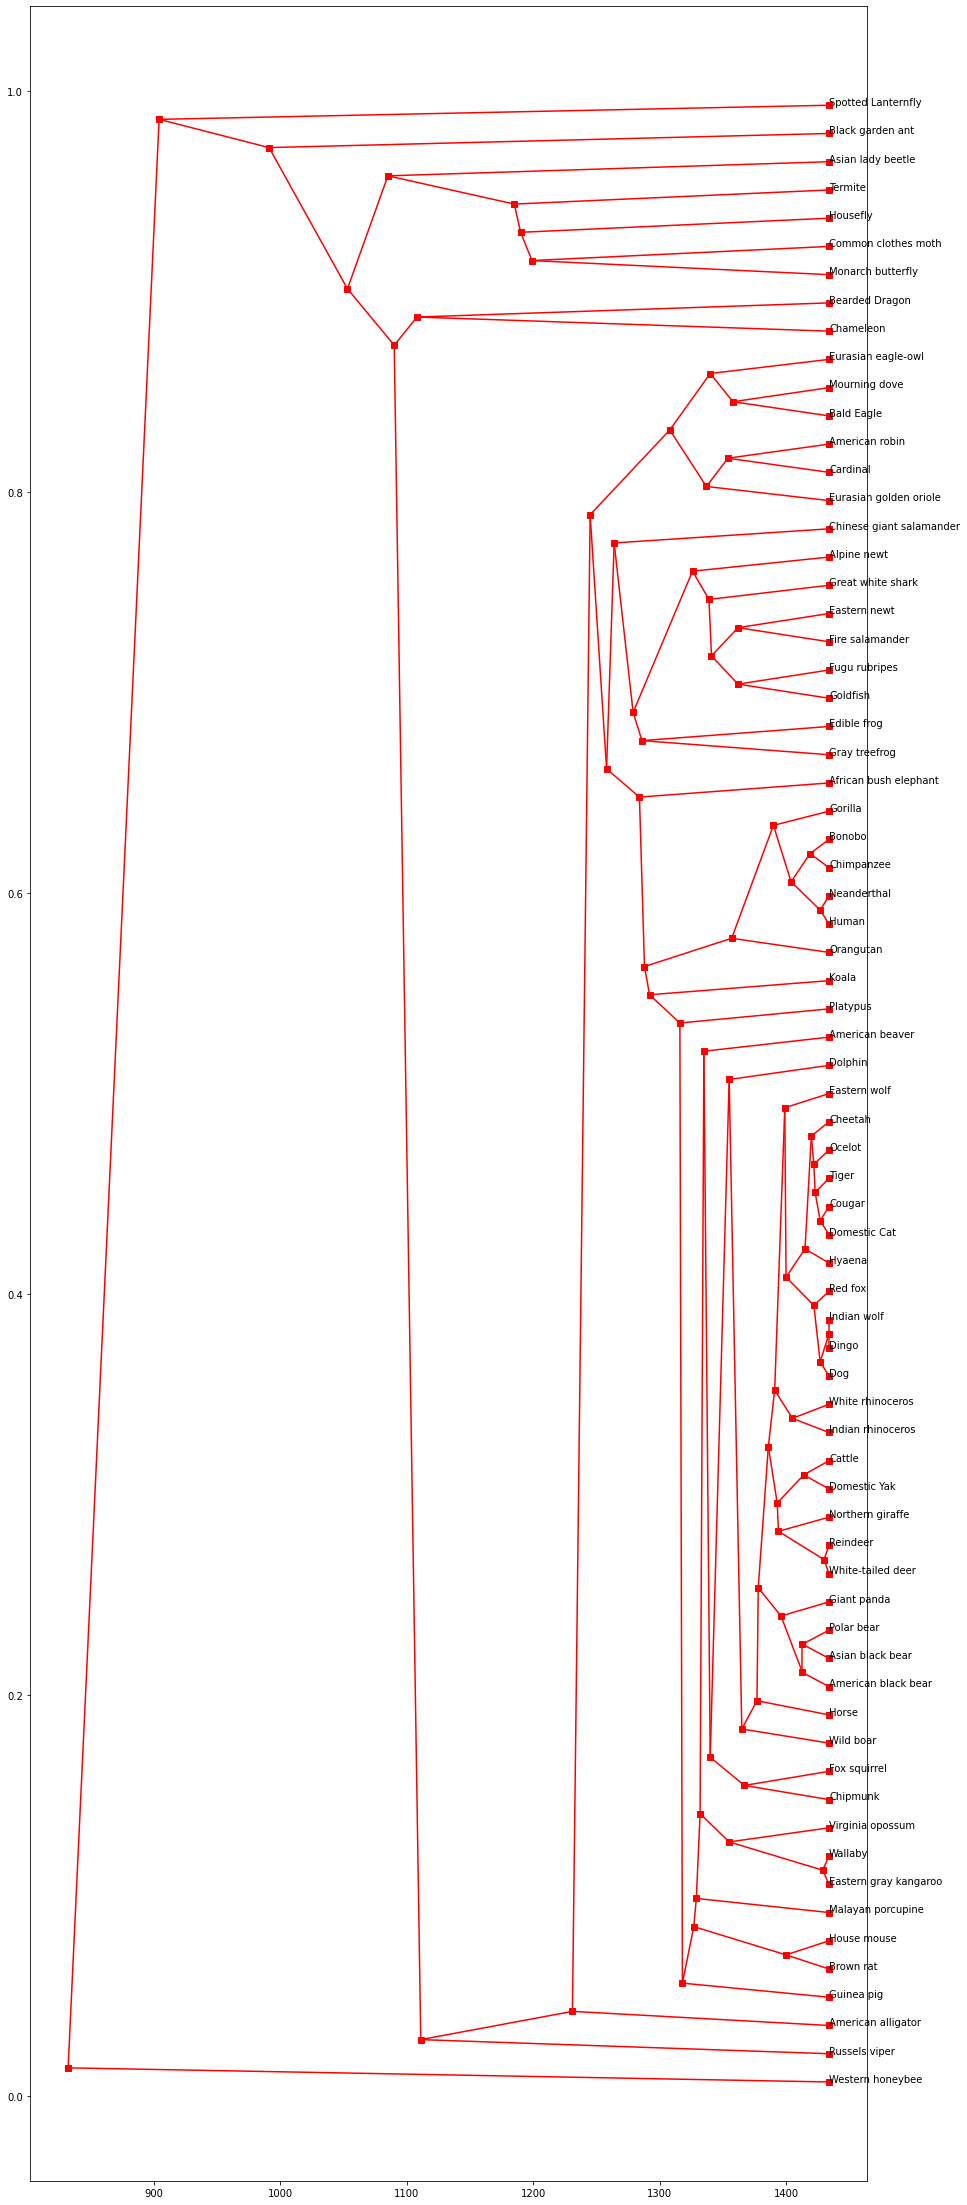

In [ ]:
plt.figure(figsize=(15, 40))
root._draw_dendrogram(0, 1)

Try clustering 

In [ ]:
def _leafs(self, nodes):
    if not (self.L and self.R):
        nodes.append(self)
    else:
        if self.L: self.L._leafs(nodes)        
        if self.R: self.R._leafs(nodes)

In [ ]:
TreeNode._leafs = _leafs

In [ ]:
def _get_clusters(self, thresh_cluster, clusters):
    if self._w < -thresh_cluster:
        nodes = []
        self._leafs(nodes)
        clusters.append(nodes)
    else:
        if self.L: self.L._get_clusters(thresh_cluster, clusters)
        if self.R: self.R._get_clusters(thresh_cluster, clusters)

In [ ]:
TreeNode._get_clusters = _get_clusters

In [ ]:
clusters = []
root._get_clusters(1260, clusters)

In [ ]:
for cluster in clusters:
    print(f'{len(cluster)} - {cluster}')

1 - [Western honeybee - Western honeybee]
1 - [Russels viper - Russels viper]
1 - [American alligator - American alligator]
44 - [Guinea pig - Guinea pig, Brown rat - Brown rat, House mouse - House mouse, Malayan porcupine - Malayan porcupine, Eastern gray kangaroo - Eastern gray kangaroo, Wallaby - Wallaby, Virginia opossum - Virginia opossum, Chipmunk - Chipmunk, Fox squirrel - Fox squirrel, Wild boar - Wild boar, Horse - Horse, American black bear - American black bear, Asian black bear - Asian black bear, Polar bear - Polar bear, Giant panda - Giant panda, White-tailed deer - White-tailed deer, Reindeer - Reindeer, Northern giraffe - Northern giraffe, Domestic Yak - Domestic Yak, Cattle - Cattle, Indian rhinoceros - Indian rhinoceros, White rhinoceros - White rhinoceros, Dog - Dog, Dingo - Dingo, Indian wolf - Indian wolf, Red fox - Red fox, Hyaena - Hyaena, Domestic Cat - Domestic Cat, Cougar - Cougar, Tiger - Tiger, Ocelot - Ocelot, Cheetah - Cheetah, Eastern wolf - Eastern wolf,

In [ ]:
clusters = []
root._get_clusters(1350, clusters)

In [ ]:
for cluster in clusters:
    print(f'{len(cluster)} - {cluster}')

1 - [Western honeybee - Western honeybee]
1 - [Russels viper - Russels viper]
1 - [American alligator - American alligator]
1 - [Guinea pig - Guinea pig]
2 - [Brown rat - Brown rat, House mouse - House mouse]
1 - [Malayan porcupine - Malayan porcupine]
3 - [Eastern gray kangaroo - Eastern gray kangaroo, Wallaby - Wallaby, Virginia opossum - Virginia opossum]
2 - [Chipmunk - Chipmunk, Fox squirrel - Fox squirrel]
25 - [Wild boar - Wild boar, Horse - Horse, American black bear - American black bear, Asian black bear - Asian black bear, Polar bear - Polar bear, Giant panda - Giant panda, White-tailed deer - White-tailed deer, Reindeer - Reindeer, Northern giraffe - Northern giraffe, Domestic Yak - Domestic Yak, Cattle - Cattle, Indian rhinoceros - Indian rhinoceros, White rhinoceros - White rhinoceros, Dog - Dog, Dingo - Dingo, Indian wolf - Indian wolf, Red fox - Red fox, Hyaena - Hyaena, Domestic Cat - Domestic Cat, Cougar - Cougar, Tiger - Tiger, Ocelot - Ocelot, Cheetah - Cheetah, Eas

# Build

In [ ]:
build_notebook()

<IPython.core.display.Javascript object>

Converted hw5.ipynb.
